# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак
* Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from catboost import CatBoostRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder

### Первичный осмотр данных

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
print("Пропуски:")
df.isna().sum()

Пропуски:


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [5]:
# Удалим ненужные столбцы
df = df.drop(["DateCrawled", "PostalCode", "LastSeen", "RegistrationMonth", "DateCreated", 'NumberOfPictures'], axis=1)


### Работа с пропусками

In [6]:
df['VehicleType'] = df['VehicleType'].fillna('Unknown')
df['Model'] = df['Model'].fillna('Unknown')

In [7]:
# Создадим словарь модель: кузов
type_of_model = df.groupby('Model')['VehicleType'].agg(lambda x:x.value_counts().index[0]).to_dict()

In [8]:
# Напиишем функцию замены типа машины
def replacement(row):
    model = row['Model']
    vehicletype = row['VehicleType']
    if model == 'Unknown' and  vehicletype == 'Unknown':
        return 'Unknown'
    elif model == 'Unknown' and  vehicletype != 'Unknown':
        return vehicletype
    
    return type_of_model[model]

df['VehicleType'] = df[['VehicleType', 'Model']].apply(replacement, axis=1)

In [9]:
# Будем считать пропуски в столбце "NotRepaired" за отуствием ремонта
df["NotRepaired"].fillna("yes", inplace=True)

In [10]:
# Удалим оставшиеся пропуски
df.dropna(inplace=True)
print("Пропуски:")
df.isna().sum()

Пропуски:


Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

In [11]:
#Заменим в "NotRepaired" yes на 1 , no на 0
df['NotRepaired'] = df['NotRepaired'].map({'yes':1, 'no':0})

### Поиск аномальных значений

In [12]:
sorted(df['RegistrationYear'].unique())

[1000,
 1200,
 1400,
 1600,
 1910,
 1919,
 1923,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2800,
 2900,
 3500,
 3700,
 5000,
 6000,
 6500,
 7500,
 9000]

In [13]:
# Избавимся от явных выбросов в RegistrationYear 
df = df[df['RegistrationYear'] >= 1910]
df = df[df['RegistrationYear'] <= 2019]

In [14]:
# Избавимся от автомобилей мощностью свыше 1000 лс
df = df[df['Power']<=1000]

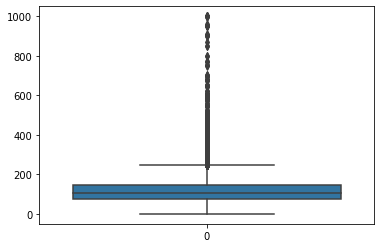

In [15]:
# Рассмотрим распределение мощности автомобилей
sns.boxplot(data=df['Power'])

In [16]:
# Сохраним категориальные признаки для работы с catboost и lightgbm
df_categorical = df.copy()
categorical = ['Brand','Model','VehicleType','Gearbox','FuelType']

In [17]:
# приведем категориальные признаки в номинальные с помощью OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(df[['Brand','Model','VehicleType','Gearbox','FuelType']])
df[['Brand','Model','VehicleType','Gearbox','FuelType']] = enc.transform(df[['Brand','Model','VehicleType','Gearbox','FuelType']])

### Вывод
Мы провели предобработку данных:  
* Удалили ненужные столбцы
* Заполнили частично пропуски
* Удалили оставшиеся пропуски
* Заменили в "NotRepaired" yes на 1 , no на 0
* Избавимся от автомобилей мощностью свыше 1000 лс
* Привели категориальные признаки в номинальные с помощью LabelEncoder
* Стандартизировали признаки с помощью StandardScaler

## Обучение моделей

In [18]:
X = df.drop('Price', axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12345)
print('Размер обучающей выборки:', X_train.shape[0])
print('Размер тренировочной выборки:', X_test.shape[0])

Размер обучающей выборки: 217214
Размер тренировочной выборки: 93093


In [19]:
df_categorical[categorical] = df_categorical[categorical].astype('category')

In [20]:
X_categorical = df_categorical.drop('Price', axis=1)
y_categotical = df_categorical['Price']
X_categorical_train, X_categorical_test, y_categotical_train, y_categotical_test = train_test_split(X_categorical, 
                                                                                                    y_categotical, 
                                                                                                    test_size = 0.3, 
                                                                                                    random_state = 12345)
print('Размер обучающей выборки:', X_categorical_train.shape[0])
print('Размер тренировочной выборки:', X_categorical_test.shape[0])

Размер обучающей выборки: 217214
Размер тренировочной выборки: 93093


In [22]:
# Стандартизируем признаки с помощью StandardScaler
scaler = StandardScaler()
numeric = ['RegistrationYear','Power','Kilometer']
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [23]:
# Напишем функцию rmse
def rmse(pred, target):
    return np.sqrt(mse(pred,target))

In [24]:
# функция для вывода
def conclusion(model, rmse, f_time, p_time):
    a = print('RMSE модели', model,':',rmse)
    b = print('Время обучения:',f_time,'секунд')
    c = print('Время предсказания:', p_time,'секунд')

In [25]:
rmse_list = []
fit_time = []
predict_time = []

### Catboost (not tunned)

In [26]:
# Обучим модель катбуста и посчитаем время обучения
cat = CatBoostRegressor(cat_features=categorical, random_state=12345)

start = time.time()
cat.fit(X_categorical_train, y_categotical_train, verbose=False);
end = time.time()
catboost_fit_time = end - start

In [27]:
start = time.time()
prediction_cat = cat.predict(X_categorical_test)
end = time.time()

catboost_predict_time = end - start

In [28]:
rmse_cat = rmse(prediction_cat, y_categotical_test)

rmse_list.append(rmse_cat)
fit_time.append(catboost_fit_time)
predict_time.append(catboost_predict_time)

In [29]:
conclusion('CatBoost (not tunned)',rmse_cat, catboost_fit_time, catboost_predict_time)

RMSE модели CatBoost (not tunned) : 1818.2600530248378
Время обучения: 585.4054760932922 секунд
Время предсказания: 0.7008249759674072 секунд


### CatBoost (tunned)

In [ ]:
grid = {'l2_leaf_reg': [1, 3, 5, 7],  
       'learning_rate': [0.1, 1, 3],  
       'max_depth': [6, 10]}  
       
cat = CatBoostRegressor(iterations=500, max_depth=10, learning_rate = 0.1, cat_features=categorical,  verbose=False)  

grid_cat = GridSearchCV(estimator=cat, param_grid=grid)  

grid_cat.fit(X_categorical_train, y_categotical_train)  

grid_cat.best_params_  

In [30]:
start = time.time()
cat = CatBoostRegressor(iterations=500, max_depth=10, learning_rate = 0.1, l2_leaf_reg = 1, cat_features=categorical,  verbose=False)
cat.fit(X_categorical_train, y_categotical_train)
end = time.time()
grid_cat_fit_time = end - start

In [31]:
start = time.time() 
prediction_grid_cat = cat.predict(X_categorical_test) 
end = time.time() 
grid_cat_prediction_time = end - start

In [32]:
rmse_cat_grid = rmse(prediction_grid_cat, y_categotical_test)

rmse_list.append(rmse_cat_grid) 
fit_time.append(grid_cat_fit_time) 
predict_time.append(grid_cat_prediction_time)

conclusion('CatBoost (tunned)',rmse_cat_grid, grid_cat_fit_time, grid_cat_prediction_time)


RMSE модели CatBoost (tunned) : 1736.409480765919
Время обучения: 543.8872935771942 секунд
Время предсказания: 1.3041183948516846 секунд


### LightGBM (not tunned)

In [33]:
lgbm = LGBMRegressor(categorical_feature=categorical)
start = time.time()
lgbm.fit(X_categorical_train, y_categotical_train,)
end = time.time()
lgbm_fit_time = end - start

In [34]:
start = time.time()
prediction_lgbm = lgbm.predict(X_categorical_test)
end = time.time()

lgbm_predict_time = end - start

In [35]:
rmse_lgbm = rmse(prediction_lgbm, y_categotical_test)

rmse_list.append(rmse_lgbm)
fit_time.append(lgbm_fit_time)
predict_time.append(lgbm_predict_time)

In [36]:
conclusion('LightGBM (not tunned)',rmse_lgbm, lgbm_fit_time, lgbm_predict_time)

RMSE модели LightGBM (not tunned) : 1786.780239610406
Время обучения: 430.69659948349 секунд
Время предсказания: 1.3017120361328125 секунд


### LightGBM (tunned)

In [ ]:
LightGBM_grid = LGBMRegressor(   
    boosting_type="gbdt",    
    random_state=10,   
    n_estimators=50,  
    num_leaves=30,   
    max_depth=8,  
    feature_fraction=0.5,    
    bagging_fraction=0.8,   
    bagging_freq=15,   
    learning_rate=0.01,      
)   

params_opt = {'n_estimators':range(200, 600, 80),   
    'num_leaves':range(20,60,10)  
    }    

gridSearchCV = GridSearchCV(estimator = LightGBM_grid,   
    param_grid = params_opt,  
    n_jobs=4,  
    iid=False,   
    verbose=1,  
    cv=3)  
    
gridSearchCV.fit(X_categorical_train, y_categotical_train)  

gridSearchCV.best_params_  

In [37]:
lgbm_grid = LGBMRegressor(n_estimators = 520, num_leaves = 50, categorical_feature=categorical, max_depth=8, 
                          feature_fraction=0.5, bagging_fraction=0.8, bagging_freq=15, boosting_type="gbdt", 
                          random_state=12345)
start = time.time()
lgbm_grid.fit(X_categorical_train, y_categotical_train)
end = time.time()
lgbm_grid_fit_time = end - start

In [38]:
start = time.time()
prediction_lgbm_grid = lgbm_grid.predict(X_categorical_test)
end = time.time()

lgbm_grid_predict_time = end - start

In [39]:
rmse_lgbm_grid = rmse(prediction_lgbm_grid, y_categotical_test)

rmse_list.append(rmse_lgbm_grid)
fit_time.append(lgbm_grid_fit_time)
predict_time.append(lgbm_grid_predict_time)

conclusion('LightGBM (tunned)',rmse_lgbm_grid, lgbm_grid_fit_time, lgbm_grid_predict_time)

RMSE модели LightGBM (tunned) : 1725.7331022963149
Время обучения: 1623.9685785770416 секунд
Время предсказания: 10.51085352897644 секунд


### Linear regression

In [40]:
lr = LinearRegression(normalize=True)
start = time.time()
lr.fit(X_train, y_train)
end = time.time()
lr_fit_time = end - start

In [41]:
start = time.time()
lr_prediction = lr.predict(X_test)
end = time.time()
lr_predict_time = end-start

In [42]:
rmse_lr = rmse(lr_prediction, y_test)

rmse_list.append(rmse_lr)
fit_time.append(lr_fit_time)
predict_time.append(lr_predict_time)

In [43]:
conclusion('Linear regression (not tunned)',rmse_lr, lr_fit_time, lr_predict_time)

RMSE модели Linear regression (not tunned) : 3114.9977316363484
Время обучения: 0.11040806770324707 секунд
Время предсказания: 0.04317116737365723 секунд


### RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor()  

grid_rfr = {   
    'n_estimators': range(50, 100, 10),    
    'max_depth' : range(5, 50, 5)  
}  

rfr_grid = GridSearchCV(estimator=rfr, param_grid=grid_rfr, cv= 3)  
rfr_grid.fit(X_train, y_train)  

rfr_grid.best_params_   


In [44]:
start = time.time()
rfr_best = RandomForestRegressor(max_depth = 45, n_estimators = 90)
rfr_best = rfr_best.fit(X_train, y_train)
end = time.time()
rfr_fit_time = end - start

In [45]:
start = time.time()
rfr_prediction = rfr_best.predict(X_test)
end = time.time()
rfr_predict_time = end-start

In [46]:
rmse_rfr = rmse(rfr_prediction, y_test)

rmse_list.append(rmse_rfr)
fit_time.append(rfr_fit_time)
predict_time.append(rfr_predict_time)

In [47]:
conclusion('RandomForestRegressor (tunned)',rmse_rfr, rfr_fit_time, rfr_predict_time)

RMSE модели RandomForestRegressor (tunned) : 1781.7970552305555
Время обучения: 53.83959889411926 секунд
Время предсказания: 3.7813382148742676 секунд


### Вывод
Мы обучили 5 моделей. В процессе работы были использованы модели с градиентным бустингом (CatBoost (not tunned), CatBoost (tunned), LightGBM (not tunned), LightGBM (tunned)), так и классические модели (Linear regression, RandomForestRegressor). Для 3-ех из них мы подбирали гиперпараметры

## Анализ моделей

In [48]:
results = pd.DataFrame(data = [rmse_list, fit_time, predict_time], index = ['RMSE', 'Fit_time', 'Predict_time'],
                      columns = ['CatBoost (not tunned)', 'CatBoost (tunned)', 
                                 'LightGBM (not tunned)', 'LightGBM (tunned)', 
                                 'Linear regression', 'RandomForestRegressor (tunned)'])

In [49]:
results

,CatBoost (not tunned),CatBoost (tunned),LightGBM (not tunned),LightGBM (tunned),Linear regression,RandomForestRegressor (tunned)
RMSE,1818.260053,1736.409481,1786.780240,1725.733102,3114.997732,1781.797055
Fit_time,585.405476,543.887294,430.696599,1623.968579,0.110408,53.839599
Predict_time,0.700825,1.304118,1.301712,10.510854,0.043171,3.781338


### Вывод
Лучший результат показали Catboost, LightGBM и RandomForestRegressor с модифицированными гиперпараметрами (1725.73, 1736.40, 1781.79 соответственно), но по времени обучения выигрывается RandomForestRegressor, его скорость обучения 54 сек против 572 сек у Catboost и 1623 у LightGBM. Поэтому я рекомендовал бы RandomForestRegressor для данного проекта, так как согласно задаче нам важно время обучения модели. 

## Общий вывод

На этапе предобработки данных были выполнены следующие шаги:
* Удалили ненужные столбцы
* Заполнили частично пропуски
* Удалили оставшиеся пропуски
* Заменили в "NotRepaired" yes на 1 , no на 0
* Избавимся от автомобилей мощностью свыше 1000 лс
* Привели категориальные признаки в номинальные с помощью LabelEncoder
* Стандартизировали признаки с помощью StandardScaler

На этапе обучения модели мы обучили 5 моделей. В процессе работы были использованы модели с градиентным бустингом (CatBoost (not tunned), CatBoost (tunned), LightGBM (not tunned), LightGBM (tunned)), так и классические модели (Linear regression, RandomForestRegressor). Для 3-ех из них мы подбирали гиперпараметры.

На этапе анализа моделей мы пришли к выводу, что лучший результат показали Catboost и LightGBM с модифицированными гиперпараметрами (1733.09 и 1726.69 соответственно), но по времени обучения выигрывается LightGBM, его скорость обучения 45 сек против 572 сек у Catboost. Поэтому я рекомендовал бы LightGBM для данного проекта. 